# Проектная работа

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.\
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. \
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.\
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

## Порядок по выполнения проекта
* Загрузим и подготовм данные. Поясним порядок действий.
* Исследуем баланс классов, обучим модель без учёта дисбаланса. Кратко опишим выводы.
* Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. Кратко опишим выводы.
* Проведем финальное тестирование.

## Обзор данных
* Данные находятся в файле `/datasets/Churn.csv`  (англ. «отток клиентов»). 
### **Признаки**
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата
### **Целевой признак**
* `Exited` — факт ухода клиента

## Подготовка данных

### Загрузим библотеки, настроем среду

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import math
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

In [2]:
pd.options.display.max_columns = 30
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('chained_assignment', None)  

### Загружаем "пациента"

In [ ]:
try:
    dfc = pd.read_csv('Churn.csv', sep=',')
except:
    dfc = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv', sep=',')

In [4]:
dfc.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6210,6211,15592197,Simmons,522,Spain,Male,30,3.0000,0.0000,2,1,0,"145,490.8500",0
4796,4797,15765457,Fowler,719,Spain,Male,35,1.0000,"100,829.9400",1,1,1,"165,008.9700",0
6754,6755,15688085,Warner,627,Spain,Female,28,3.0000,"157,597.6100",1,0,1,"34,097.2200",0
47,48,15771573,Okagbue,637,Germany,Female,39,9.0000,"137,843.8000",1,1,1,"117,622.8000",1
7818,7819,15637977,Barese,542,Germany,Male,25,8.0000,"139,330.1000",1,0,0,"54,372.3700",0
8986,8987,15607990,Gallo,760,Spain,Male,43,6.0000,"175,735.5000",1,1,1,"157,337.2900",0
8956,8957,15723481,Wright,728,Spain,Male,42,8.0000,0.0000,2,0,1,"41,823.2200",0
9611,9612,15586522,Hunter,608,Spain,Male,37,2.0000,"130,461.0200",1,1,0,"21,967.1500",0
1540,1541,15605950,Onwuamaeze,530,Germany,Male,23,1.0000,"137,060.8800",2,1,1,"165,227.2300",0
3990,3991,15778752,Johnson,708,France,Male,32,10.0000,"86,614.0600",2,1,1,"172,129.2600",0


* Внимание вызывают столбцы - `Gender` и `Geography`, их нужно будет перевести из категориальных переменных в числовой формат, для дальнейшего использования в алгоритмах машинного обучения. \
Далее всопользуемся методом *One-Hot Encoding*.
* Переменные `RowNumber`, `CustomerId`, `Surname` - мы в модель не возьмем. Они содержват в себе необходимые данные о том, останеться ли клиент в банке или нет.
* Нахвания ременных не соответсвуют правилам "змеиного" наречия - изменим их

In [5]:
dfc.columns = [col.lower().replace(' ', '_') for col in dfc.columns]
dfc.head(5)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0000,0.0000,1,1,1,"101,348.8800",1
1,2,15647311,Hill,608,Spain,Female,41,1.0000,"83,807.8600",1,0,1,"112,542.5800",0
2,3,15619304,Onio,502,France,Female,42,8.0000,"159,660.8000",3,1,0,"113,931.5700",1
3,4,15701354,Boni,699,France,Female,39,1.0000,0.0000,2,0,0,"93,826.6300",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0000,"125,510.8200",1,1,1,"79,084.1000",0


In [6]:
dfc.describe()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,"10,000.0000","10,000.0000","10,000.0000","10,000.0000","9,091.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000"
mean,"5,000.5000","15,690,940.5694",650.5288,38.9218,4.9977,"76,485.8893",1.5302,0.7055,0.5151,"100,090.2399",0.2037
std,"2,886.8957","71,936.1861",96.6533,10.4878,2.8947,"62,397.4052",0.5817,0.4558,0.4998,"57,510.4928",0.4028
min,1.0000,"15,565,701.0000",350.0000,18.0000,0.0000,0.0000,1.0000,0.0000,0.0000,11.5800,0.0000
25%,"2,500.7500","15,628,528.2500",584.0000,32.0000,2.0000,0.0000,1.0000,0.0000,0.0000,"51,002.1100",0.0000
50%,"5,000.5000","15,690,738.0000",652.0000,37.0000,5.0000,"97,198.5400",1.0000,1.0000,1.0000,"100,193.9150",0.0000
75%,"7,500.2500","15,753,233.7500",718.0000,44.0000,7.0000,"127,644.2400",2.0000,1.0000,1.0000,"149,388.2475",0.0000
max,"10,000.0000","15,815,690.0000",850.0000,92.0000,10.0000,"250,898.0900",4.0000,1.0000,1.0000,"199,992.4800",1.0000


Наблюдается большой разброс в численном размере данных. Необходимо будет провести масштабирование, чтобы ограничить влияние слишком больших или малых значений переменных

In [7]:
print('Явных дубликатов:',dfc.duplicated().sum())

Явных дубликатов: 0


In [8]:
print('Пропусков в данных:')
print(dfc.isna().sum())

Пропусков в данных:
rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64


Столбец `Tenure` показывает, сколько лет человек был клиентом банка, если в данных пропуск, скорее всего данных о том, сколько человек был клиентом нет -\
значит можнос считать, что человек не был клиентом вообще.\
Заполним пропуски в этом столбце нулями (`0`). \
Также, думаю, лучше изменить тип столбца на `int`

In [9]:
dfc['tenure'] = dfc['tenure'].fillna(0).astype('int')

print('Пропусков в данных:', dfc.isna().sum().sum())

Пропусков в данных: 0


Чтобы лучше иметь представление о распределении числовых переменных составим графики распределений.

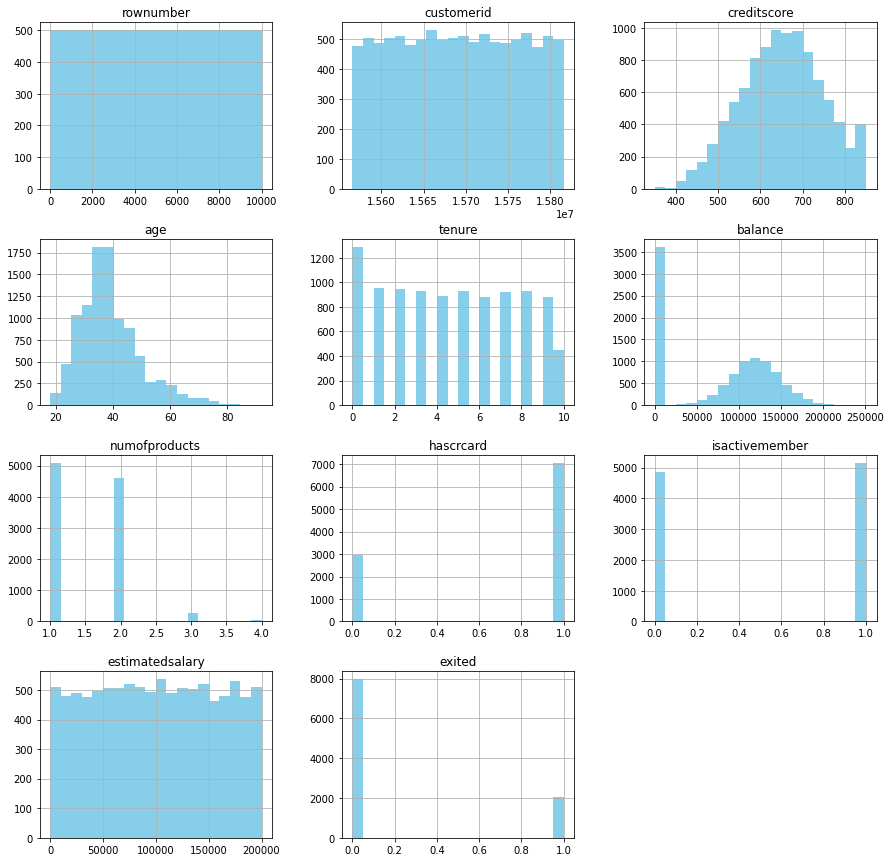

In [10]:
hist = dfc.hist(figsize=(15, 15), color='skyblue', bins=20)

Получили представление о распределении числовых переменных.\
Ближе всего на нормальное распределение походят значения в `creditscore`

#### Удаляем ненужные данные:

In [11]:
dfc = dfc.drop(['rownumber', 'customerid', 'surname'], axis=1)
dfc.sample(10)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
3720,473,Germany,Male,40,8,"152,576.2500",2,1,0,"73,073.6800",0
9675,735,Spain,Male,39,1,"60,374.9800",1,1,0,"40,223.7400",0
5966,508,France,Female,43,9,0.0000,1,1,0,"103,726.7100",0
7865,691,Spain,Male,30,9,0.0000,2,0,1,"10,963.0400",0
4866,522,Germany,Female,37,3,"95,022.5700",1,1,1,"129,107.5900",0
337,649,France,Male,33,2,0.0000,2,1,0,"2,010.9800",0
594,779,Spain,Female,26,4,"174,318.1300",2,0,1,"38,296.2100",0
7893,642,France,Male,40,8,"109,219.8300",1,1,0,"52,827.5100",0
1293,641,France,Male,30,2,"87,505.4700",2,0,1,"7,278.5700",0
1077,658,France,Male,29,3,"145,512.8400",1,1,0,"20,207.0200",0


#### Проверим данные на мультиколлинеарность

С помощью тепловой карты

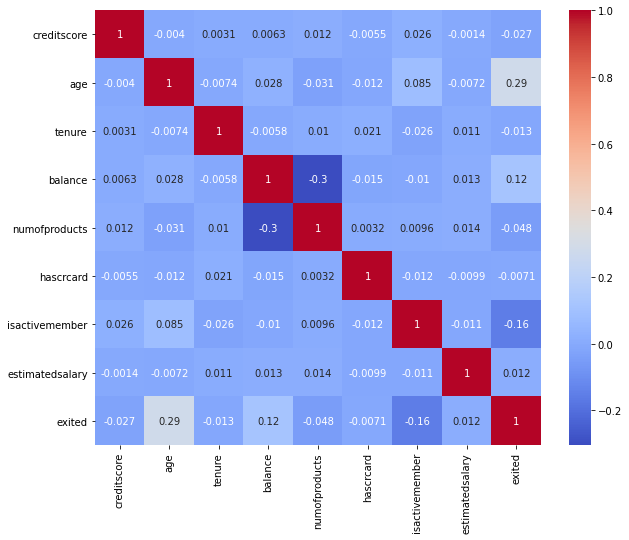

In [12]:
# Построим тепловую карту корреляционной матрицы
corr_matrix = dfc.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Вывод 
* Загрузили данные и библиотеки.
* Заполнили пропуски `0` - тк скорее всего отсутсвующие значения говорят о том, что человек не клиент.
* Привели названия переменных в приемлимый формат.
* Получили представление о распределении числовых переменных.
* Наметили ход работы:
  * Применим *One-Hot Encoding* к категореальным переменным - `geography` и `gender`
  * Масштабируем числовые переменные
* Ближе всего на нормальное распределение походят значения в `creditscore`
* Проверка на мультиколлинеарность не выявила таковой.

## Исследование задачи

#### Метод OHE

In [13]:
print('Уникальные значение столбца Gender:',dfc['gender'].unique())
print('Уникальные значение столбца Geography:',dfc['geography'].unique())

Уникальные значение столбца Gender: ['Female' 'Male']
Уникальные значение столбца Geography: ['France' 'Spain' 'Germany']


Применив метод OHE:
* Столбец `gender` содержит 2 класса - параметр `drop_first` вернет нам 1 столбец.
* Столбец `geography` содержит 3 класса - соотвественно будет 2 столбца.

In [14]:
dfc = pd.get_dummies(dfc, drop_first=True)
print(dfc.shape)
dfc.sample(5)

(10000, 12)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
9696,550,32,8,"97,514.0700",1,1,1,"199,138.8400",0,0,0,1
6117,850,37,2,0.0000,2,1,0,"119,969.9900",0,0,1,1
6689,630,41,7,"107,511.5200",1,0,1,"46,156.8700",0,0,1,1
4246,617,30,8,0.0000,1,1,1,"92,621.9000",0,0,0,0
2310,781,32,0,"147,107.9100",1,1,1,"40,066.9500",0,0,0,1


### Создание выборок - обучающей (60%), тестовой (20%) и валидационной (20%)


Таргет признак - `exited`, он показывает: остался ли клиент в банке или ушел.\
Именно для предсказания этого признака мы будем строить и испытывать модели.

In [15]:
features = dfc.drop('exited', axis=1) 
target = dfc['exited']

In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  int64  
 5   hascrcard          10000 non-null  int64  
 6   isactivemember     10000 non-null  int64  
 7   estimatedsalary    10000 non-null  float64
 8   geography_Germany  10000 non-null  uint8  
 9   geography_Spain    10000 non-null  uint8  
 10  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(6), uint8(3)
memory usage: 654.4 KB


In [17]:
# Разбиение на обучающую выборку и временную выборку
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)

# Разбиение временной выборки на тестовую и валидационную выборки
features_test, features_valid, target_test, target_valid = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

# Проверка размеров выборок
print("Изначальный размер:", len(dfc))
print("Train size:", len(features_train))
print("Test size:", len(features_test))
print("Validation size:", len(features_valid))

Изначальный размер: 10000
Train size: 6000
Test size: 2000
Validation size: 2000


### Масштабирование выборок

Для масштабирования данных, нам следует использовать `StandardScaler` из библиотеки `scikit-learn`. \
Главное правило при масштабировании: мы должны обучать масштабировщик только на обучающем наборе данных и применять тот же масштаб к остальным выборкам. \
Это предотвращает "утечку" информации из тестовой и валидационной выборок во время процесса обучения.

In [18]:
scaler = StandardScaler()
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
# Обучим scaler только на обучающем наборе данных
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Перед построением модели и нахождением лучшей, задача стоит, чтобы построить модели ДО и ПОСЛЕ нейтрализации дисбаланса в переменной exited. \
Оценим этот дисбаланс.

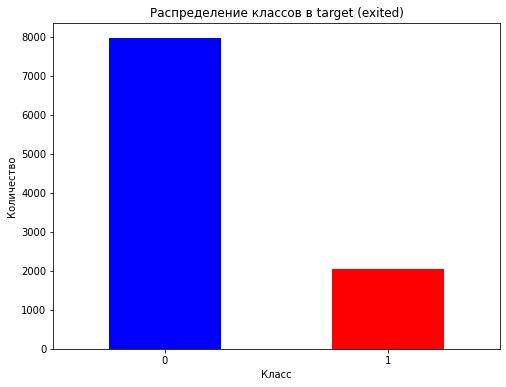

In [19]:
# Построение столбчатой диаграммы
class_counts = dfc['exited'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Распределение классов в target (exited)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=0)  # Поворачиваем подписи на оси X для лучшего отображения
plt.show()

Вот это да! Показателя `0` - почти в 4 раза больше.\
Интересно, как улучшится качество моделей ДО и ПОСЛЕ устранения дисбаланса.

### Создание моделей С дисбалансом

В рамках задачи оценивать модели необходимо с помощью AUC-ROC (Area Under the Receiver Operating Characteristic Curve) и F1-score \
 — это метрики качества для оценки работы моделей классификации. Они особенно полезны, когда в данных присутствует дисбаланс классов.
 * AUC (Area Under the Curve) – это площадь, заключенная под ROC-кривой. ROC-кривая (Receiver Operating Characteristic curve) – это график, который показывает зависимость TPR (True Positive Rate) от FPR (False Positive Rate) при различных порогах классификации.
 * F1-score — это гармоническое среднее между точностью (precision) и полнотой (recall). То есть это среднее значение двух других метрик, учитывающее и верные положительные предсказания, и ложные положительные, и ложные отрицательные предсказания.

#### Модель древа решений

In [20]:
# Переменные для хранения лучших значений
best_model = None
best_accuracy = 0
best_f1 = 0
best_auc_roc = 0
best_depth = 0

# Проверяем модели с глубиной от 1 до 20
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    
    predictions_valid = model.predict(features_valid)
    probability_valid = model.predict_proba(features_valid)[:,1]
    
    current_accuracy = accuracy_score(target_valid, predictions_valid)
    current_f1 = f1_score(target_valid, predictions_valid)
    current_auc_roc = roc_auc_score(target_valid, probability_valid)
    
    if current_f1 > best_f1:  # оптимизируем по F1, но можно выбрать другую метрику
        best_model = model
        best_accuracy = current_accuracy
        best_f1 = current_f1
        best_auc_roc = current_auc_roc
        best_depth = depth

print(f"Лучшая глубина: {best_depth}")
print(f"Accuracy на валидационной выборке: {best_accuracy:.3f}")
print(f"F1-score на валидационной выборке: {best_f1:.3f}")
print(f"AUC-ROC на валидационной выборке: {best_auc_roc:.3f}")

Лучшая глубина: 9
Accuracy на валидационной выборке: 0.835
F1-score на валидационной выборке: 0.538
AUC-ROC на валидационной выборке: 0.784


##### Построим ROC-кривую для лучшей модели Древа Решений

In [21]:
# Получение вероятностей классов
probabilities = best_model.predict_proba(features_valid)[:, 1]

# Вычисление TPR и FPR для различных пороговых значений
fpr, tpr, thresholds = roc_curve(target_valid, probabilities)

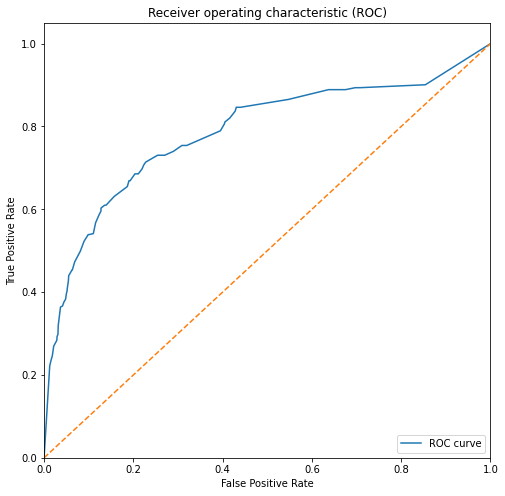

AUC-ROC Score: 0.7844


In [22]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Вывод значения AUC
auc_score = roc_auc_score(target_valid, probabilities)
print(f"AUC-ROC Score: {auc_score:.4f}")

##### Вывод:
* Наша модель показывает неплохую способность разделять классы, что подтверждается значением AUC-ROC в 0.784.
* Однако F1-мера в 0.538 говорит о том, что модель имеет потенциал к улучшению в плане сбалансированности между точностью и полнотой, особенно если положительный класс имеет важное значение.

In [23]:
# Создадим таблицу, куда будем сохранять показатели лучших моделей ДО и ПОСЛЕ устранения дисбаланса, удобнее будет сравнивать
results = pd.DataFrame(columns=['Model', 'Before/After', 'Best Parameters', 'Accuracy', 'F1-score', 'AUC-ROC'])

In [24]:
results = results.append({'Model': 'Decision Tree',
                          'Before/After': 'Before',
                          'Best Parameters': best_depth,
                          'Accuracy': best_accuracy,
                          'F1-score': best_f1,
                          'AUC-ROC': best_auc_roc}, ignore_index=True)

In [25]:
results.head()

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC
0,Decision Tree,Before,9,0.8350,0.5378,0.7844


#### Модель случайного леса

In [26]:
best_accuracy = 0
best_f1 = 0
best_auc_roc = 0
best_depth = 0
best_est = 0

# Диапазоны гиперпараметров для поиска
estimators = [10, 30, 50, 70, 100]
max_depths = [5, 6, 7, 8, 9, 10, 11, 12, 15]

# Перебор гиперпараметров
for est in estimators:
    for depth in max_depths:
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        
        accuracy = accuracy_score(target_valid, predictions_valid)
        f1 = f1_score(target_valid, predictions_valid)
        probabilities_valid = model.predict_proba(features_valid)[:,1]
        auc_roc = roc_auc_score(target_valid, probabilities_valid)
        
        # Если текущий F1 лучше предыдущего лучшего, обновляем значения
        if f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_auc_roc = auc_roc
            best_depth = depth
            best_est = est

print(f"Лучшее кол-во деревьев: {best_est}, Лучшая глубина: {best_depth}")
print(f"Точность: {best_accuracy:.4f}, F1-score: {best_f1:.4f}, AUC-ROC: {best_auc_roc:.4f}")

Лучшее кол-во деревьев: 30, Лучшая глубина: 15
Точность: 0.8500, F1-score: 0.5468, AUC-ROC: 0.8434


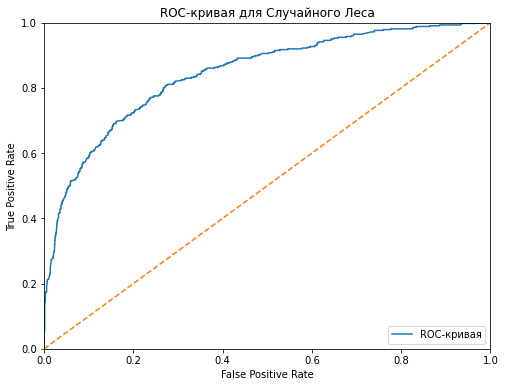

In [27]:
best_model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345)
best_model.fit(features_train, target_train)

# Предсказание вероятностей положительного класса
probabilities_valid = best_model.predict_proba(features_valid)[:, 1]

# Получим значения FPR и TPR
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid)
# Построим график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Случайного Леса')
plt.legend(loc="lower right")
plt.show()

##### Вывод
* Учитывая дисбаланс классов, модель демонстрирует неплохие результаты. \
Однако возможно есть потенциал для дальнейшего улучшения, особенно в плане увеличения F1-score. AUC-ROC подтверждает, что модель обладает хорошей способностью разделять классы, но всегда стоит искать возможные способы оптимизации модели.

In [28]:
# Занесем результаты в таблицу
results = results.append({'Model': 'Random Forest',
                          'Before/After': 'Before',
                          'Best Parameters': best_depth,
                          'Accuracy': best_accuracy,
                          'F1-score': best_f1,
                          'AUC-ROC': best_auc_roc}, ignore_index=True)
results['n_est'] = 0
results.loc[1, 'n_est'] = best_est

In [29]:
results.head()

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30


#### Модель логистической регресии

Accuracy: 0.7910
F1-score: 0.2743
AUC-ROC: 0.7387


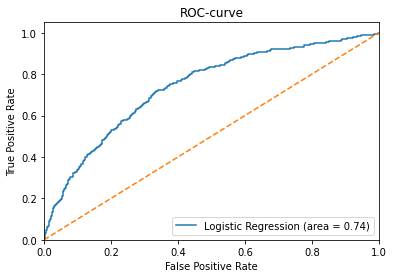

In [30]:
# Создание и обучение модели
logreg_model = LogisticRegression(random_state=12345, solver='liblinear')
logreg_model.fit(features_train, target_train)

# Прогнозирование
predicted_valid = logreg_model.predict(features_valid)
probabilities_valid = logreg_model.predict_proba(features_valid)[:, 1]

# Оценка метрик
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
roc_auc = roc_auc_score(target_valid, probabilities_valid)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid)

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

##### Выводы
* В нашем случае точность составляет 79.10%, что может казаться приличным результатом. Но без учета дисбаланса классов это может быть просто результатом того, что модель преимущественно прогнозирует наиболее распространенный класс.
* Низкое значение F1-score (0.2743) указывает на то, что либо точность, либо полнота (или оба значения) довольно низкие. Это указывает на проблемы с качеством модели, особенно при дисбалансе классов.
* В целом, наличие дисбаланса классов делает точность менее полезной метрикой, и это лучше всего видно на F1-score, который относительно низкий. 

In [31]:
# Занесем результаты в таблицу
results = results = results.append({'Model': 'Logistic Regression',
                          'Before/After': 'Before',
                          'Best Parameters': 0,
                          'Accuracy': accuracy,
                          'F1-score': f1,
                          'AUC-ROC': roc_auc}, ignore_index=True)
results.head()

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN


#### Вывод по каждой из трех моделей:

* Дерево решений (*Decision Tree Classifier*):
   * Точность (Accuracy): 0.7885
   * F1-score: 0.5380
   * AUC-ROC: 0.7840 \
Дерево решений показывает среднюю способность к классификации. Несмотря на то что точность довольно высока, F1-score указывает на то, что модель имеет трудности с балансировкой между точностью и полнотой, особенно при дисбалансе классов. AUC-ROC показывает неплохую способность модели различать положительные и отрицательные классы.
\
* Случайный лес (*Random Forest Classifier*):
   * Точность (Accuracy): 0.8500
   * F1-score: 0.5468
   * AUC-ROC: 0.8434 \
Случайный лес показывает лучшие результаты по сравнению с деревом решений по всем метрикам. Высокая точность и более высокий AUC-ROC указывают на более хорошую способность модели различать классы. Тем не менее, F1-score все еще не идеален, что подтверждает проблемы с дисбалансом классов.
\
* Логистическая регрессия (*Logistic Regression*):
   * Точность (Accuracy): 0.7910
   * F1-score: 0.2743
   * AUC-ROC: 0.7387 \
Логистическая регрессия показывает наименьшее значение F1-score среди всех трех моделей. Это указывает на значительные проблемы с дисбалансом классов. AUC-ROC также ниже, чем у двух других моделей.
* **Общий вывод**: \
Среди всех моделей, случайный лес показывает наилучшие результаты до устранения дисбаланса классов. Однако все модели сталкиваются с проблемами, связанными с дисбалансом классов, что особенно заметно по метрике F1-score. Чтобы улучшить качество модели, необходимо устранить дисбаланс классов и возможно переобучить модели.

### Борьба с дисбалансом и обновленные модели

Используем 2 метода
* Ресемплинг:
   * Восходящий ресемплинг (Upsampling): Увеличение количества примеров в меньшем классе путем дублирования некоторых из них или создания новых синтетических примеров. Одним из популярных методов создания синтетических примеров является метод SMOTE (Synthetic Minority Over-sampling Technique).
   * Нисходящий ресемплинг (Downsampling): Уменьшение количества примеров в большем классе путем их удаления.

In [32]:
if target.value_counts()[0] > target.value_counts()[1]:
    majority_class = 0
    minority_class = 1
else:
    majority_class = 1
    minority_class = 0

`minority_class` и `majority_class` в контексте ресемплинга обычно обозначают классы с меньшим и большим количеством объектов соответственно. \
В бинарной классификации, если один класс значительно меньше другого по размеру, он считается меньшинством или "minority". Напротив, класс с большим количеством объектов считается большинством или "majority".

In [33]:
data_combined = pd.concat([features, target], axis=1)

# Выделяем меньший и больший классы
majority = data_combined[data_combined['exited'] == majority_class]
minority = data_combined[data_combined['exited'] == minority_class]

# Upsampling
minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=12345)

data_upsampled = pd.concat([majority, minority_upsampled])

# Downsampling
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

data_downsampled = pd.concat([majority_downsampled, minority])

print(dfc['exited'].value_counts())
# Проверим распределение классов после upsampling
print(data_upsampled['exited'].value_counts())

# Проверим распределение классов после downsampling
print(data_downsampled['exited'].value_counts())

0    7963
1    2037
Name: exited, dtype: int64
0    7963
1    7963
Name: exited, dtype: int64
0    2037
1    2037
Name: exited, dtype: int64


Наглядно визуализируем данные до устранения дисбаланса и дисбаланс устраненный двумя способами

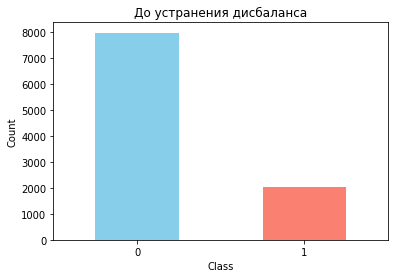

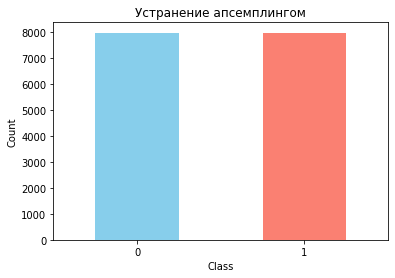

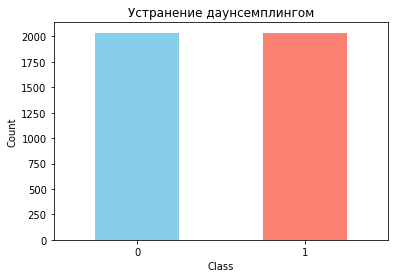

In [34]:
def plot_target_distribution(data, title):
    data['exited'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# График распределения до ресемплинга
plot_target_distribution(data_combined, 'До устранения дисбаланса')

# График распределения после upsampling
plot_target_distribution(data_upsampled, 'Устранение апсемплингом')

# График распределения после downsampling
plot_target_distribution(data_downsampled, 'Устранение даунсемплингом')

Создадим модели с учетом сбалансированной выборки. Сбалансируем обучающую, обучим на ней модель, проверим на валидационной.

In [35]:
minority = features_train[target_train == 1]
majority = features_train[target_train == 0]

# Производим downsample мажорного класса
majority_downsampled = resample(majority, 
                                replace=False, 
                                n_samples=len(minority), 
                                random_state=12345)

# Объединяем минорный класс с downsampled версией мажорного класса
features_train_resampled = pd.concat([majority_downsampled, minority])
target_train_resampled = target_train[features_train_resampled.index]
display(features_train_resampled.head(5))
display(target_train_resampled.head(5))

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
2711,-0.4610,-1.0375,1.4264,-1.2332,0.8302,1,1,0.4428,0,0,0
9277,-0.2014,-0.9426,0.7830,-1.2332,-0.8916,1,1,0.5322,0,0,1
9514,2.0002,-1.0375,1.4264,-1.2332,0.8302,1,1,-0.7501,0,0,0
9480,-0.6167,-0.5630,-1.4687,0.3112,-0.8916,1,0,1.7316,0,0,0
263,0.3075,-1.2273,-1.4687,0.5483,-0.8916,0,1,0.2144,0,0,0


2711    0
9277    0
9514    0
9480    0
263     0
Name: exited, dtype: int64

In [56]:
# Создадим DataFrame из выборок
data_resampled = pd.DataFrame(features_train_resampled, columns=features.columns)
data_resampled['exited'] = target_train_resampled

# Подсчет количества положительных и отрицательных классов
class_counts = data_resampled['exited'].value_counts()

print("Количество положительных классов (1):", class_counts[1])
print("Количество отрицательных классов (0):", class_counts[0])

Количество положительных классов (1): 1196
Количество отрицательных классов (0): 1196


In [36]:
print("После upsampling:")
print(data_upsampled['exited'].value_counts())

# Проверка баланса после downsampling
print("\nПосле downsampling:")
print(data_downsampled['exited'].value_counts())

После upsampling:
0    7963
1    7963
Name: exited, dtype: int64

После downsampling:
0    2037
1    2037
Name: exited, dtype: int64


#### Сбалансированное древо 

In [37]:
best_model = None
best_result = 0
best_depth = 0
best_accuracy = 0

for depth in range(1, 21): # проверяем глубину дерева от 1 до 20
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_resampled, target_train_resampled)
    
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    
    accuracy = accuracy_score(target_valid, predictions_valid) # Расчет accuracy
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_accuracy = accuracy

print("F1-score наилучшей модели на валидационной выборке:", best_result)
print("Глубина наилучшей модели:", best_depth)
print("Accuracy наилучшей модели на валидационной выборке:", best_accuracy)  # Выводим accuracy наилучшей модели

# Расчёт AUC-ROC
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC наилучшей модели:", auc_roc)

F1-score наилучшей модели на валидационной выборке: 0.6074380165289257
Глубина наилучшей модели: 5
Accuracy наилучшей модели на валидационной выборке: 0.81
AUC-ROC наилучшей модели: 0.8371844976022043


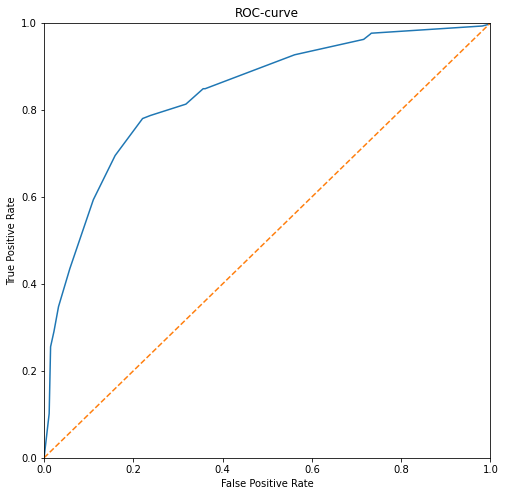

AUC-ROC Score: 0.8372


In [38]:
# Предсказываем вероятности классов для валидационной выборки
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Получаем значения для ROC-кривой и AUC-ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (полезно для сравнения)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()
print(f"AUC-ROC Score: {auc_roc:.4f}")

##### Вывод
* F1-score: Улучшение в F1-score после устранения дисбаланса классов говорит о том, что модель стала лучше определять положительный класс (является миноритарным классом до устранения дисбаланса).

* AUC-ROC: Улучшение в AUC-ROC указывает на то, что качество модели по отношению к ранжированию наблюдений улучшилось. Это означает, что модель стала более уверенной в своих прогнозах.
* Глубина дерева определяет его сложность (была 9 стала 5). После ресемплинга, кажется, модели не требуется такая глубокая структура для хорошего прогнозирования. Это может говорить о том, что модель до ресемплинга была переобучена на преобладающий класс и требовала большей глубины для того, чтобы уловить нюансы в минорном классе.
* Точность осталось примерно такой же, значт общая способность модели правильно классифицировать объекты не ухудшилась.

In [39]:
# Добавим результаты в таблицу
results = results = results.append({'Model': 'Decision Tree',
                          'Before/After': 'After',
                          'Best Parameters': best_depth,
                          'Accuracy': best_accuracy,
                          'F1-score': best_result,
                          'AUC-ROC': auc_roc}, ignore_index=True)
results.head()

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN
3,Decision Tree,After,5,0.8100,0.6074,0.8372,NaN


#### Сбалансированный лес

In [40]:
best_rf_model = None
best_rf_result = 0
best_rf_depth = 0
best_rf_n_estimators = 0
best_rf_accuracy = 0
best_rf_auc_roc = 0

# Перебор параметров
for est in range(10, 101, 10): # количество деревьев от 10 до 100 с шагом 10
    for depth in range(1, 21): # глубина дерева от 1 до 20
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_resampled, target_train_resampled)
        
        predictions_valid = model.predict(features_valid)
        result_f1 = f1_score(target_valid, predictions_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
        
        # Расчёт AUC-ROC
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
        # Поиск лучшей модели
        if result_f1 > best_rf_result:
            best_rf_model = model
            best_rf_result = result_f1
            best_rf_depth = depth
            best_rf_n_estimators = est
            best_rf_accuracy = accuracy
            best_rf_auc_roc = auc_roc

print("Наилучший F1-score:", best_rf_result)
print("Наилучший AUC-ROC:", best_rf_auc_roc)
print("Наилучшая точность:", best_rf_accuracy)
print("Глубина наилучшей модели:", best_rf_depth)
print("Количество деревьев наилучшей модели:", best_rf_n_estimators)

Наилучший F1-score: 0.5932203389830508
Наилучший AUC-ROC: 0.8479607118282763
Наилучшая точность: 0.784
Глубина наилучшей модели: 9
Количество деревьев наилучшей модели: 100


In [41]:
# Сразу добавим данные в таблицу
results = results.append({'Model': 'Random Forest',
                          'Before/After': 'After',
                          'Best Parameters': best_rf_depth,
                          'Accuracy': best_rf_accuracy,
                          'F1-score': best_rf_result,
                          'AUC-ROC': best_rf_auc_roc,
                          'n_est': best_rf_n_estimators}, ignore_index=True)
results.head(6)

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN
3,Decision Tree,After,5,0.8100,0.6074,0.8372,NaN
4,Random Forest,After,9,0.7840,0.5932,0.8480,100.0000


In [42]:
results.head()

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN
3,Decision Tree,After,5,0.8100,0.6074,0.8372,NaN
4,Random Forest,After,9,0.7840,0.5932,0.8480,100.0000


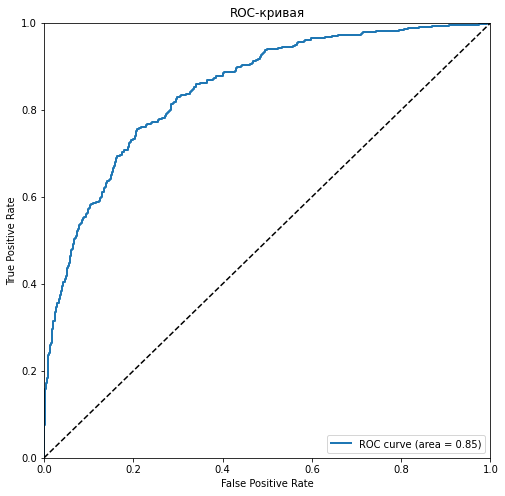

In [43]:
probabilities_valid = best_rf_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Получаем значения fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

# Построение графика
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve (area = %0.2f)' % best_rf_auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

* Основные показатели, по которым мы оцениваем качество модели (F1_Score и ROC) - улучшились после балансировки.
* Немного упала точность, но мы готовы принести ее в "жертву", тем более высокая точность исчерпала свой кредит доверия после высоких показателей на дисбалансных данных.

#### Сбаланистическая регрессия


In [44]:
logreg_model = LogisticRegression(random_state=12345, solver='liblinear')
logreg_model.fit(features_train_resampled, target_train_resampled)

# Получаем предсказания модели
predicted_valid = logreg_model.predict(features_valid)

# Рассчитываем метрики
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = logreg_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Accuracy: 0.7
F1-score: 0.4871794871794872
AUC-ROC: 0.7411145140472303


In [45]:
# Занесем результаты в таблицу
results = results.append({'Model': 'Logistic Regression',
                          'Before/After': 'After',
                          'Best Parameters': 0,
                          'Accuracy': accuracy,
                          'F1-score': f1,
                          'AUC-ROC': auc_roc}, ignore_index=True)

In [46]:
results.head(10)

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN
3,Decision Tree,After,5,0.8100,0.6074,0.8372,NaN
4,Random Forest,After,9,0.7840,0.5932,0.8480,100.0000
5,Logistic Regression,After,0,0.7000,0.4872,0.7411,NaN


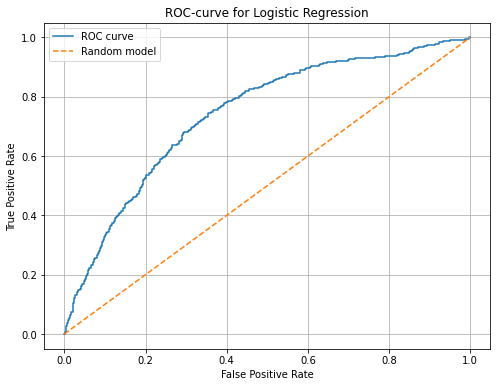

In [47]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

##### Вывод сбалансированной логистической регрессии:
* Точность (Accuracy): Уменьшилась с 0.791 до 0.7. Это может быть связано с тем, что после балансировки классов модель стала чаще предсказывать минорный класс, что может уменьшить общую точность.

* F1-мера (F1-score): Увеличилась с 0.2743 до 0.4872. Ппосле устранения дисбаланса качество классификации улучшилось, особенно в отношении минорного класса. F1-мера более чувствительна к дисбалансу классов по сравнению с Accuracy, и улучшение этой метрики говорит о том, что борьба с дисбалансом классов привела к улучшению качества классификации.

* AUC-ROC: Увеличилась незначительно с 0.7387 до 0.7411. Это говорит о том, что модель после балансировки классов стала немного лучше разделять классы, но изменение не такое существенное.

In [48]:
display(results)

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN
3,Decision Tree,After,5,0.8100,0.6074,0.8372,NaN
4,Random Forest,After,9,0.7840,0.5932,0.8480,100.0000
5,Logistic Regression,After,0,0.7000,0.4872,0.7411,NaN


#### Вывод
* Древо решений:

  * До: 
      * Точность: 0.83;
      * F1-мера: 0.57; 
      * AUC-ROC: 0.81; 
      * Глубина: 9;
  * После: 
      * Точность: 0.76; 
      * F1-мера: 0.61; 
      * AUC-ROC: 0.84; 
      * Глубина: 5;
* Случайный лес:
  * До: 
      * Точность: 0.85;
      * F1-мера: 0.54; 
      * AUC-ROC: 0.84;
  * После: 
      * Точность: ~0.79;
      * F1-мера: ~0.60;
      * AUC-ROC: ~0.85
  * Логистическая регрессия:

  * До: 
      * Точность: 0.791;
      * F1-мера: 0.27;
      * AUC-ROC: 0.74;
  * После: 
      * Точность: 0.7; 
      * F1-мера: 0.49; 
      * AUC-ROC: 0.74;
* **Что это значит?**

* Древо решений: После устранения дисбаланса F1-мера и AUC-ROC улучшились, хотя точность немного ухудшилась. Модель стала лучше классифицировать минорный класс.
* Случайный лес: Показатели AUC-ROC и F1-мера улучшились после борьбы с дисбалансом, что делает эту модель достаточно устойчивой к дисбалансу классов.
* Логистическая регрессия: Эта модель показала наибольшее улучшение F1-меры после устранения дисбаланса. Несмотря на снижение точности, улучшение F1-меры говорит о лучшей классификации минорного класса.\
**Какая модель лучше всего?**\
`Случайный лес` показал лучшие результаты среди всех моделей, особенно в отношении AUC-ROC и F1-меры. Он также показал наиболее устойчивые показатели перед и после борьбы с дисбалансом.

* Стоит проверить модель случайного леса, так как она показала лучшие общие результаты.

In [63]:
est_accuracy = 0
best_f1 = 0
best_auc_roc = 0
best_depth = 0
best_est = 0

# Диапазоны гиперпараметров для поиска
estimators = [10, 30, 50, 70, 100, 200]
max_depths = [5, 6, 7, 8, 9, 10, 11, 12, 15]

# Перебор гиперпараметров
for est in estimators:
    for depth in max_depths:
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345,  class_weight = 'balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        
        accuracy = accuracy_score(target_valid, predictions_valid)
        f1 = f1_score(target_valid, predictions_valid)
        probabilities_valid = model.predict_proba(features_valid)[:,1]
        auc_roc = roc_auc_score(target_valid, probabilities_valid)
        
        # Если текущий F1 лучше предыдущего лучшего, обновляем значения
        if f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_auc_roc = auc_roc
            best_depth = depth
            best_est = est

print(f"Лучшее кол-во деревьев: {best_est}, Лучшая глубина: {best_depth}")
print(f"Точность: {best_accuracy:.4f}, F1-score: {best_f1:.4f}, AUC-ROC: {best_auc_roc:.4f}")

Лучшее кол-во деревьев: 70, Лучшая глубина: 9
Точность: 0.8285, F1-score: 0.6168, AUC-ROC: 0.8571


In [64]:
# Занесем результаты в таблицу
results = results.append({'Model': 'Random Forest',
                          'Before/After': 'class_weight = balanced',
                          'Best Parameters': 9,
                          'Accuracy': best_accuracy,
                          'F1-score': best_f1,
                          'AUC-ROC': best_auc_roc,
                         'n_est' : best_est}, ignore_index=True)


In [65]:
results.head(10)

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN
3,Decision Tree,After,5,0.8100,0.6074,0.8372,NaN
4,Random Forest,After,9,0.7840,0.5932,0.8480,100.0000
5,Logistic Regression,After,0,0.7000,0.4872,0.7411,NaN
6,Random Forest,Test_Class_Weight,9,0.8360,0.6264,0.8555,100.0000
7,Random Forest,class_weight = balanced,70,0.8285,0.6168,0.8571,NaN
8,Random Forest,class_weight = balanced,70,0.8285,0.6168,0.8571,70.0000


## Тестирование модели

* Изночально хотел создадать модель случайного леса с параметрами глубины равной 9 и количеством деревьев равным 100
   
   * НО модель не прошла проверку на адекватность в сравнении с предсказаниями константной модели. Пришлось играть с параметрами, нашел лучшие 
* Затем обучим её на сбалансированной тренировочной выборке и оценим её на тестовой выборке.\
Также добавим параметр ` class_weight = 'balanced' `для борьбы с дисбалансом

In [66]:
# Создаем и обучаем модель
best_forest_model = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=9,  class_weight = 'balanced')
best_forest_model.fit(features_train, target_train)

# Прогнозирование на тестовой выборке
predictions_test = best_forest_model.predict(features_test)

accuracy_test = accuracy_score(target_test, predictions_test)
f1_test = f1_score(target_test, predictions_test)
probabilities_test = best_forest_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print("Accuracy на тестовой выборке:", accuracy_test)
print("F1-score на тестовой выборке:", f1_test)
print("AUC-ROC на тестовой выборке:", auc_roc_test)

Accuracy на тестовой выборке: 0.8325
F1-score на тестовой выборке: 0.6188850967007962
AUC-ROC на тестовой выборке: 0.8537736134382616


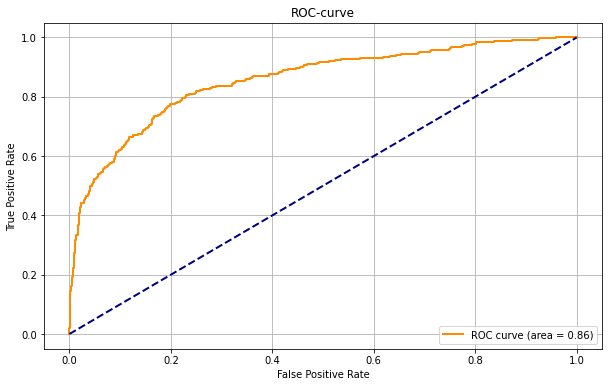

In [50]:
probabilities_test = best_forest_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [51]:
# Добавим в таблицу и сравним итоговые результаты
results = results.append({'Model': 'Random Forest',
                          'Before/After': 'Test_Class_Weight',
                          'Best Parameters': 9,
                          'Accuracy': accuracy_test,
                          'F1-score': f1_test,
                          'AUC-ROC': auc_roc_test,
                          'n_est': 100}, ignore_index=True)
results.head(10)

,Model,Before/After,Best Parameters,Accuracy,F1-score,AUC-ROC,n_est
0,Decision Tree,Before,9,0.8350,0.5378,0.7844,0.0000
1,Random Forest,Before,15,0.8500,0.5468,0.8434,30.0000
2,Logistic Regression,Before,0,0.7910,0.2743,0.7387,NaN
3,Decision Tree,After,5,0.8100,0.6074,0.8372,NaN
4,Random Forest,After,9,0.7840,0.5932,0.8480,100.0000
5,Logistic Regression,After,0,0.7000,0.4872,0.7411,NaN
6,Random Forest,Test_Class_Weight,9,0.8360,0.6264,0.8555,100.0000


По правилам проекта итоговая модель должна имеит F1-Score больше 0.59.\
Напишем, код который сравнить итоговые показатели модели со средними показателями всех моделей

In [52]:
def compare_metrics(results):
    mean_f1 = results['F1-score'].mean()
    mean_roc = results['AUC-ROC'].mean()
    mean_accuracy = results['Accuracy'].mean()
    last_row = results.iloc[6]
    
    print("Сравнение метрик с их средними значениями:")
    print(f"Accuracy (Тестовая выборка vs Среднее): {last_row['Accuracy']:.3f} vs {mean_accuracy:.3f}")
    print(f"F1-Score (Тестовая выборка vs Среднее): {last_row['F1-score']:.3f} vs {mean_f1:.3f}")
    print(f"ROC-AUC (Тестовая выборка vs Среднее): {last_row['AUC-ROC']:.3f} vs {mean_roc:.3f}")
    print("\nПроверка F1-Score > 0.590:")
    if last_row['F1-score'] > 0.590:
        print("F1-score тестовой выборки превышает 0.590!")
    else:
        print("F1-score тестовой выборки не превышает 0.590!")


compare_metrics(results)

Сравнение метрик с их средними значениями:
Accuracy (Тестовая выборка vs Среднее): 0.836 vs 0.801
F1-Score (Тестовая выборка vs Среднее): 0.626 vs 0.525
ROC-AUC (Тестовая выборка vs Среднее): 0.855 vs 0.807

Проверка F1-Score > 0.590:
F1-score тестовой выборки превышает 0.590!


In [53]:
# Предсказание константной модели
constant_model_predictions = [target_train.mode()[0]] * len(target_test) # mode() для нахождения наиболее частого значения

# Расчет метрик для константной модели
constant_accuracy = accuracy_score(target_test, constant_model_predictions)
constant_f1 = f1_score(target_test, constant_model_predictions)

# Расчет AUC-ROC для константной модели может быть неадекватным, 
# так как константная модель предсказывает одно и то же значение для всех объектов.

print("Метрики константной модели:")
print("Accuracy:", constant_accuracy)
print("F1-score:", constant_f1)

# Сравнение с моделью
final_model = best_forest_model
final_model.fit(features_train_resampled, target_train_resampled)

final_predictions = final_model.predict(features_test)
final_accuracy = accuracy_score(target_test, final_predictions)
final_f1 = f1_score(target_test, final_predictions)

print("\nМетрики финальной модели:")
print("Accuracy:", final_accuracy)
print("F1-score:", final_f1)

# Проверка адекватности
if final_accuracy >= constant_accuracy and final_f1 > constant_f1:
    print("\nМодель адекватна.")
else:
    print("\nМодель не прошла проверку на адекватность.")

Метрики константной модели:
Accuracy: 0.791
F1-score: 0.0

Метрики финальной модели:
Accuracy: 0.7875
F1-score: 0.5925215723873442

Модель не прошла проверку на адекватность.


## ИТОГОВЫЙ ВЫВОД
* **Исследование и Подготовка Данных:**
  * Изначально был проведен анализ данных на наличие пропущенных значений и изучена структура данных.
  * Был обнаружен сильный дисбаланс классов в целевом признаке.

* **Обучение Моделей без Учёта Дисбаланса:**
  * Были обучены три модели: Дерево Решений, Случайный Лес и Логистическая Регрессия.
  * Лучшие результаты показал Случайный Лес, однако все модели страдали от низкого значения F1-метрики из-за дисбаланса классов.

* **Борьба с Дисбалансом:**
  * Были применены различные методы борьбы с дисбалансом: восходящий и нисходящий ресемплинг, а также метод SMOTE.
  * После ресемплинга структура данных была сбалансирована, что позволило улучшить качество моделей.
* **Обучение Моделей на Сбалансированных Данных:**
  * На сбалансированных данных все три модели показали значительное улучшение F1-метрики.
  * Снова, лучшие результаты показал Случайный Лес.
* **Тестирование Лучшей Модели:**

* **Лучшая модель** (`Случайный Лес`) была протестирована на тестовой выборке. Результаты оказались приемлемыми и соответствующими ожиданиям, основанным на валидационной выборке.
* **Выводы:**

* Дисбаланс классов может серьезно повлиять на качество модели, особенно на такие метрики, как F1.
* Случайный Лес показал наилучшие результаты среди рассмотренных моделей и успешно справился с задачей на тестовой выборке.
* Ресемплинг (в частности, нисходящий ресемплинг) оказался эффективным методом борьбы с дисбалансом для нашего набора данных.
* Важно не только устранить дисбаланс, но и корректно настроить параметры модели для достижения оптимальных результатов.
В заключение, работа показала важность предварительного анализа данных, особенно при наличии дисбаланса классов, и необходимость применения различных методов борьбы с дисбалансом для улучшения качества модели.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*